# Hidden Markov Model on Macro Regime

# Packages

In [33]:
import pandas as pd
import numpy as np
import statsmodels as sm
import os
import glob
import re
from pathlib import Path
from functools import reduce
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Data Processing 

## vix: S&P500 vol index
## vxn: Nasdaq vol index
## vxd: DJIA vol index

## 1.1 Volatility Indicies

In [34]:
project_root = Path().resolve()
data_dir = project_root / "data" 
macro_data_dir = data_dir / "Macro"
commodities_data_dir = data_dir / "Commodities"
indices_data_dir = data_dir / "Indices"

index_vol = pd.read_csv(f'{data_dir}/Macro/VIX_Data/vix_data.csv')
vvix = pd.read_csv(f'{data_dir}/Macro/VIX_Data/VVIX_History.csv')
vxv = pd.read_csv(f'{data_dir}/Macro/VIX_Data/VIX3M.csv')
cesi = pd.read_csv(f'{data_dir}/Indices/CESI_index.csv')

In [35]:

index_vol['Date'] = pd.to_datetime(index_vol['Date'], format='%Y-%m-%d')

vvix.rename(columns={'DATE': 'Date', 'VVIX': 'vvix'}, inplace=True)
vvix['Date'] = pd.to_datetime(vvix['Date'])

vxv.rename(columns={'PX_LAST': 'vxv'}, inplace=True)
vxv['Date'] = pd.to_datetime(vxv['Date'], format='%Y/%m/%d')
vxv = vxv[['Date', 'vxv']]

cesi.rename(columns={'PX_LAST': 'cesi'}, inplace=True)
cesi['Date'] = pd.to_datetime(cesi['Date'], format='%Y/%m/%d')
cesi = cesi[['Date', 'cesi']]

data_frames_to_merge = [index_vol, vvix, vxv, cesi]

volatility_df = data_frames_to_merge[0]

for df in data_frames_to_merge[1:]:
    volatility_df = pd.merge(volatility_df, df, on='Date', how='inner')

volatility_df = volatility_df.sort_values(by='Date')
volatility_df = volatility_df.set_index('Date')

volatility_df.dropna(how='all')

print(volatility_df.head())

             vixo   vixh   vixl    vix   vxno   vxnh   vxnl    vxn   vxdo  \
Date                                                                        
2006-03-06  12.22  12.91  12.22  12.74  16.60  17.71  16.58  17.52  11.74   
2006-03-15  11.17  11.54  10.98  11.35  15.59  15.65  14.90  15.44  10.88   
2006-03-16  10.59  12.05  10.57  11.98  15.54  15.75  15.08  15.62  10.82   
2006-03-17  11.56  12.20  11.53  12.12  15.55  15.60  14.90  15.36  10.80   
2006-03-20  11.23  12.21  11.13  11.79  15.96  16.24  15.76  15.93  11.19   

             vxdh   vxdl    vxd   vvix    vxv  cesi  
Date                                                 
2006-03-06  12.35  11.54  12.16  71.73  13.20 -45.1  
2006-03-15  11.07  10.74  10.77  15.71  12.28 -38.5  
2006-03-16  11.15  10.59  11.09  27.94  12.41 -40.1  
2006-03-17  11.08  10.60  10.87  28.60  12.63 -41.8  
2006-03-20  11.66  11.01  11.06  37.93  12.65 -40.5  


## 1.2 Global Macro Factors

In [36]:
# Growth Data

# 1. Load GDP Data
gdp_path = macro_data_dir / "GDP" / "US_GDP.csv"
gdp_df = pd.read_csv(gdp_path)

gdp_df.rename(columns={'observation_date': 'Date'}, inplace=True)
gdp_df['Date'] = pd.to_datetime(gdp_df['Date'], errors='coerce')
gdp_df.dropna(subset=['Date'], inplace=True)
gdp_df = gdp_df[['Date', 'GDP']]

# 2. Load and Combine PMI Data
pmi_path = macro_data_dir / "PMI"

pmi_filenames = [
    "China_Manufacture_PMI.csv",
    "Hungary_Manufacture_PMI.csv",
    "Isarel_Manufacture_PMI.csv", # israel?
    "NewZealand_Manufacture_PMI.csv",
    "Norway_Manufacture_PMI.csv",
    "Singapore_Manufacture_PMI.csv",
    "SouthAfrica_Manufacture_PMI.csv",
    "Sweden_Manufacture_PMI.csv",
    "Switzerland_Manufacture_PMI.csv",
    "US_Manufacture_PMI.csv"
]

all_pmi_files = [pmi_path / fname for fname in pmi_filenames]

pmi_df_list = []
for f_path in all_pmi_files:

    df = pd.read_csv(f_path)
        
    f_name = os.path.basename(f_path)
    country_name = f_name.split('_')[0]
        
    df.rename(columns={'DateTime': 'Date', 'Close': f'PMI_{country_name}'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[['Date', f'PMI_{country_name}']]
    df.dropna(subset=['Date'], inplace=True)
    pmi_df_list.append(df)

pmi_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), pmi_df_list)
gdp_df = gdp_df.set_index('Date').sort_index()

pmi_df = pmi_df.set_index('Date').sort_index()
start_date = min(gdp_df.index.min(), pmi_df.index.min())
end_date = pmi_df.index.max() 
daily_index = pd.date_range(start=start_date, end=end_date, freq='B')
pmi_reindexed = pmi_df.reindex(daily_index)
gdp_ffilled = gdp_df.reindex(daily_index, method='ffill')

growth_df = pd.merge(pmi_reindexed, gdp_ffilled, left_index=True, right_index=True, how='left')
growth_df.fillna(method='ffill', inplace=True)
growth_df.dropna(inplace=True)
growth_df.index.name = 'Date'
    
print(growth_df.head())

            PMI_China  PMI_Hungary  PMI_Isarel  PMI_NewZealand  PMI_Norway  \
Date                                                                         
2005-11-30       54.1        55.54        57.7            44.3       60.02   
2005-12-01       54.1        55.54        57.7            44.3       60.02   
2005-12-02       54.1        55.54        57.7            44.3       60.02   
2005-12-05       54.1        55.54        57.7            44.3       60.02   
2005-12-06       54.1        55.54        57.7            44.3       60.02   

            PMI_Singapore  PMI_SouthAfrica  PMI_Sweden  PMI_Switzerland  \
Date                                                                      
2005-11-30           53.5            52.06        57.4             56.5   
2005-12-01           53.5            52.06        57.4             56.5   
2005-12-02           53.5            52.06        57.4             56.5   
2005-12-05           53.5            52.06        57.4             56.5   
200

/tmp/ipykernel_1682/2610229912.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  growth_df.fillna(method='ffill', inplace=True)


In [37]:
from pathlib import Path
import pandas as pd

# Inflation + Energy folders
inflation_path = macro_data_dir / "Inflation"
energy_path = data_dir / "Commodities" / "Energy"

# Filenames
inflation_filenames = [
    "Australia_cpi.csv", "canada_cpi.csv", "eu_cpi.csv",
    "euro_cpi.csv", "german_cpi.csv", "japan_cpi.csv", "new_zealand_cpi.csv",
    "norway_cpi.csv", "south_africa_cpi.csv", "us_core_inflation.csv",
    "us_core_inflation_mom.csv", "us_cpi_core.csv", "us_cpi_housing.csv",
    "us_cpi_seasonaladjusted.csv", "us_cpi_transport.csv",
    "us_cpi.csv", "us_inflation_mom.csv", "us_inflation.csv", "us_PCEPI.csv"
]

energy_filenames = ["Crude_Oil_WTI.csv"]


def load_and_prep(file_path: Path, prefix=""):
    """Loads a CSV, standardizes Date, renames Close column — Pathlib version."""
    try:
        df = pd.read_csv(file_path)

        # Clean name from filename
        f_name = file_path.stem  # same as basename.replace(".csv", "")
        clean_name = f_name.replace('Manufacturing_', '')

        # Standardize date column names
        if 'DATE' in df.columns:
            df.rename(columns={'DATE': 'Date'}, inplace=True)
        elif 'DateTime' in df.columns:
            df.rename(columns={'DateTime': 'Date'}, inplace=True)
        elif 'observation_date' in df.columns:
            df.rename(columns={'observation_date': 'Date'}, inplace=True)

        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

            new_col_name = f"{prefix}{clean_name}"
            df.rename(columns={'Close': new_col_name}, inplace=True)

            df = df[['Date', new_col_name]]
            df.dropna(subset=['Date'], inplace=True)

            return df

        print(f"Warning: 'Date' column not found in {file_path}. Skipping.")
        return None

    except FileNotFoundError:
        print(f"Warning: File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


all_dfs = []

# Load inflation datasets
for f in inflation_filenames:
    df = load_and_prep(inflation_path / f, prefix="INF_")
    if df is not None:
        all_dfs.append(df)

# Load energy datasets
for f in energy_filenames:
    df = load_and_prep(energy_path / f, prefix="COM_")
    if df is not None:
        all_dfs.append(df)

print(f"Successfully loaded {len(all_dfs)} files.")

# Combine DataFrames
from functools import reduce

inflation_df = reduce(
    lambda left, right: pd.merge(left, right, on="Date", how="outer"),
    all_dfs
)

inflation_df = inflation_df.set_index("Date").sort_index()

# Create full business-day index
start_date = inflation_df.index.min()
end_date = inflation_df.index.max()
daily_index = pd.date_range(start=start_date, end=end_date, freq="B")

inflation_df = inflation_df.reindex(daily_index)
inflation_df.fillna(method="ffill", inplace=True)

# YoY crude oil
crude_col = "COM_Crude_Oil_WTI"
inflation_df[f"{crude_col}_YoY"] = (
    inflation_df[crude_col] / inflation_df[crude_col].shift(252) - 1
) * 100

inflation_df.dropna(how="any", inplace=True)
inflation_df.index.name = "Date"

print("\nInflation DataFrame Head:")
print(inflation_df.head())


/tmp/ipykernel_1682/3657888917.py:39: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Successfully loaded 19 files.

Inflation DataFrame Head:
            INF_canada_cpi  INF_eu_cpi  INF_euro_cpi  INF_german_cpi  \
Date                                                                   
2015-12-22           127.1      100.01        100.01            94.3   
2015-12-23           127.1      100.01        100.01            94.3   
2015-12-24           127.1      100.01        100.01            94.3   
2015-12-25           127.1      100.01        100.01            94.3   
2015-12-28           127.1      100.01        100.01            94.3   

            INF_japan_cpi  INF_new_zealand_cpi  INF_norway_cpi  \
Date                                                             
2015-12-22           98.1                982.1           101.3   
2015-12-23           98.1                982.1           101.3   
2015-12-24           98.1                982.1           101.3   
2015-12-25           98.1                982.1           101.3   
2015-12-28           98.1                9

/tmp/ipykernel_1682/3657888917.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inflation_df.fillna(method="ffill", inplace=True)


In [38]:
# 3. Interest Rates (Yields)
def prepare_date_df(df):
    """Standardizes Date column and converts columns to numeric."""
    df = df.copy()
    if 'DATE' in df.columns:
        df.rename(columns={'DATE': 'Date'}, inplace=True)
    if 'DateTime' in df.columns:
        df.rename(columns={'DateTime': 'Date'}, inplace=True)
        
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.set_index('Date').sort_index()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

treasury_path = macro_data_dir / "Treasury Yield"
project_root = Path().resolve()
data_dir = project_root / "data" 
indices_path = data_dir / "Indices"

bill_rate = prepare_date_df(pd.read_csv(os.path.join(treasury_path, 'Treasury Bill Yield/merged_treasury_bill_yield.csv')))
par_yield = prepare_date_df(pd.read_csv(os.path.join(treasury_path, 'Treasury Par Yield/merged_treasury_par_yield.csv')))
par_yield_real = prepare_date_df(pd.read_csv(os.path.join(treasury_path, 'Treasury Par Yield_Real/merged_treasury_par_yield_real.csv')))

hy_oas = prepare_date_df(pd.read_csv(os.path.join(indices_path, 'HY_OAS.csv'))).rename(columns={'PX_LAST': 'HY_OAS'})
ig_oas = prepare_date_df(pd.read_csv(os.path.join(indices_path, 'IG_OAS.csv'))).rename(columns={'PX_LAST': 'IG_OAS'})

features_df = pd.DataFrame()
features_df['TBill_3M'] = bill_rate['13 WEEKS COUPON EQUIVALENT']
features_df['TNote_10Y'] = par_yield['10 Yr']
features_df['TNote_2Y'] = par_yield['2 Yr']
features_df['TIPS_10Y'] = par_yield_real['10 YR']
features_df['TIPS_5Y'] = par_yield_real['5 YR']
features_df['HY_OAS'] = hy_oas['HY_OAS']
features_df['IG_OAS'] = ig_oas['IG_OAS']

all_data_merged = features_df

start_date = all_data_merged.index.min()
end_date = all_data_merged.index.max()
daily_index = pd.date_range(start=start_date, end=end_date, freq='B')

rates_features = all_data_merged.reindex(daily_index)
rates_features.fillna(method='ffill', inplace=True)

rates_features.dropna(how='any', inplace=True)
rates_features.index.name = 'Date'

# Calculate spreads
rates_features['Curve_Slope_10Y2Y'] = rates_features['TNote_10Y'] - rates_features['TNote_2Y']
rates_features['Curve_Slope_10Y3M'] = rates_features['TNote_10Y'] - rates_features['TBill_3M']
rates_features['Curve_Slope_Real_10Y5Y'] = rates_features['TIPS_10Y'] - rates_features['TIPS_5Y']
rates_features['Credit_Spread_HYIG'] = rates_features['HY_OAS'] - rates_features['IG_OAS']

print("\n--- Rates Features Tail ---")
print(rates_features.tail())


--- Rates Features Tail ---
            TBill_3M  TNote_10Y  TNote_2Y  TIPS_10Y  TIPS_5Y  HY_OAS  IG_OAS  \
Date                                                                           
2025-10-20      3.90       4.00      3.46      1.74     1.30    2.88    0.77   
2025-10-21      3.89       3.98      3.45      1.70     1.26    2.88    0.78   
2025-10-22      3.89       3.97      3.45      1.68     1.24    2.91    0.79   
2025-10-23      3.89       4.01      3.48      1.71     1.19    2.88    0.77   
2025-10-24      3.86       4.02      3.48      1.73     1.21    2.81    0.75   

            Curve_Slope_10Y2Y  Curve_Slope_10Y3M  Curve_Slope_Real_10Y5Y  \
Date                                                                       
2025-10-20               0.54               0.10                    0.44   
2025-10-21               0.53               0.09                    0.44   
2025-10-22               0.52               0.08                    0.44   
2025-10-23               0.53 

/tmp/ipykernel_1682/1891658108.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rates_features.fillna(method='ffill', inplace=True)


# 2. Feature Engineering

## 2.1 Vol Features

In [39]:
vol_raw = volatility_df.copy()
vol_features = volatility_df.copy()

def z_score(series, window):
    roll_mean = series.rolling(window=window, min_periods=window // 2).mean()
    roll_std = series.rolling(window=window, min_periods=window // 2).std()
    return (series - roll_mean) / roll_std

    
# 1. Term structure / contango
vol_features['VIX_TERM'] = vol_raw['vxv'] / vol_raw['vix']
vol_features['DOW_TERM'] = vol_raw['vxdh'] / vol_raw['vxd'] 
vol_features['NASDAQ_TERM'] = vol_raw['vxnh'] / vol_raw['vxn']
vol_features['Contango'] = (vol_features['VIX_TERM'] > 1).astype(int)

# 2. Skew / high-low ratios
vol_features['VIX_SKEW'] = vol_raw['vixh'] / vol_raw['vixl']
vol_features['VXN_SKEW'] = vol_raw['vxnh'] / vol_raw['vxnl']
vol_features['VXD_SKEW'] = vol_raw['vxdh'] / vol_raw['vxdl']

# 3. Cross-index spreads
vol_features['TECH_RISK_PREM'] = vol_raw['vxn'] - vol_raw['vix']
vol_features['INDUSTRIAL_RISK_PREM'] = vol_raw['vxd'] - vol_raw['vix']

# 4. Vol of vol / jump risk
vol_features['VVIX_z63'] = z_score(vol_raw['vvix'], 63)
vol_features['VVIX_MINUS_VIX'] = vol_raw['vvix'] - vol_raw['vix']

# 5. Level & momentum
for prefix in ['vix', 'vxn', 'vxd']:
    # Z-score (Level)
    vol_features[f'{prefix.upper()}_z63'] = z_score(vol_raw[prefix], 63)
        
    # Momentum (Price Change)
    vol_features[f'D_{prefix.upper()}_5D'] = vol_raw[prefix].diff(5)
        
    # RV_RATIO (Ratio of Level Z-Scores, as per image)
    z_21 = z_score(vol_raw[prefix], 21)
    z_252 = z_score(vol_raw[prefix], 252)
    vol_features[f'RV_RATIO_{prefix.upper()}'] = z_21 / z_252

# 6. Macro surprise overlay
vol_features['CESI_z63'] = z_score(vol_raw['cesi'], 63)
vol_features['D_CESI_20D'] = vol_raw['cesi'].diff(20)
    
# Combo feature: VIX_TERM * (CESI_z<0)
cesi_signal = (vol_features['CESI_z63'] < 0).astype(int)
vol_features['VIX_TERM_CESI'] = vol_features['VIX_TERM'] * cesi_signal

engineered_features = vol_features.drop(columns=vol_raw.columns)
engineered_features = engineered_features.dropna()

engineered_features.head()

,VIX_TERM,DOW_TERM,NASDAQ_TERM,Contango,VIX_SKEW,VXN_SKEW,VXD_SKEW,TECH_RISK_PREM,INDUSTRIAL_RISK_PREM,VVIX_z63,...,RV_RATIO_VIX,VXN_z63,D_VXN_5D,RV_RATIO_VXN,VXD_z63,D_VXD_5D,RV_RATIO_VXD,CESI_z63,D_CESI_20D,VIX_TERM_CESI
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-24,1.158434,1.000000,1.013470,1,1.028409,1.025308,1.023506,4.86,-0.28,-1.064457,...,-0.016290,-1.527818,0.23,0.539847,-0.836453,0.60,-0.036975,-0.635512,-12.9,1.158434
2006-11-27,1.091057,1.015886,1.014205,1,1.106822,1.079855,1.117755,5.30,-0.34,-0.546411,...,-7.054302,0.050912,2.27,-1.971220,1.031330,2.19,-8.902933,-0.445055,-2.9,1.091057
2006-11-28,1.117040,1.078761,1.042123,1,1.085640,1.053676,1.083556,5.71,-0.32,-1.011467,...,-2.031379,-0.162382,2.20,-1.256289,0.230101,1.55,-2.192251,-0.913226,-12.1,1.117040
2006-11-29,1.136657,1.037453,1.026818,1,1.071228,1.057055,1.051233,5.95,-0.15,-1.560986,...,-0.005928,-0.595521,1.76,-0.433600,-0.523482,1.08,-0.268601,-0.518836,2.6,1.136657
2006-11-30,1.144821,1.430320,1.046582,1,1.068053,1.067901,2.063859,5.62,-0.29,-1.406245,...,-0.172005,-0.777968,1.58,-0.182111,-0.575649,0.88,-0.153572,-0.805863,2.0,1.144821


## 2.2 Growth Features

In [40]:
growth_raw = growth_df.copy()
growth_features = growth_df.copy()

# 7. Diffusion/breadth
growth_features['PMI_US_ABOVE50'] = growth_raw['PMI_US'] - 50

g10_cols = [
    'PMI_US', 'PMI_China', 'PMI_NewZealand', 
    'PMI_Norway', 'PMI_Sweden', 'PMI_Switzerland'
]
available_g10_cols = [col for col in g10_cols if col in growth_raw.columns]
above_50 = (growth_raw[available_g10_cols] > 50).sum(axis=1)
growth_features['PMI_BREADTH_G6'] = above_50 / len(available_g10_cols)

# 8. PMI momentum & surprise
growth_features['PMI_US_MOM'] = growth_raw['PMI_US'].diff(21)
growth_features['PMI_US_Z252'] = z_score(growth_raw['PMI_US'], 252)
growth_features['PMI_SURPRISE'] = growth_raw['PMI_US'] - growth_raw['PMI_US'].rolling(252).mean()

# 9. GDP growth proxy
growth_features['GDP_YOY'] = (growth_raw['GDP'] / growth_raw['GDP'].shift(252) - 1) * 100
growth_features['D_GDP_YOY_20D'] = growth_features['GDP_YOY'].diff(20)
growth_features['GDP_YOY_z252'] = z_score(growth_features['GDP_YOY'], 252)

growth_features = growth_features.drop(columns=growth_raw.columns)
growth_features = growth_features.dropna()

growth_features.tail()

,PMI_US_ABOVE50,PMI_BREADTH_G6,PMI_US_MOM,PMI_US_Z252,PMI_SURPRISE,GDP_YOY,D_GDP_YOY_20D,GDP_YOY_z252
Date,,,,,,,,
2025-09-24,-2.0,0.500000,0.0,-0.521100,-0.607937,2.214729,-1.085881,-2.742772
2025-09-25,-2.0,0.500000,0.0,-0.523459,-0.609921,2.214729,-1.085881,-2.693415
2025-09-26,-2.0,0.500000,0.0,-0.525826,-0.611905,2.214729,-1.085881,-2.646261
2025-09-29,-2.0,0.500000,0.0,-0.528202,-0.613889,2.214729,-1.085881,-2.601145
2025-09-30,-0.9,0.166667,1.1,0.413416,0.479762,2.214729,-1.085881,-2.557920


## 2.3 Inflation Features

In [41]:
inflation_raw = inflation_df.copy()
inf_features = inflation_df.copy()

# 10. Inflation Level & Momentum
inf_features['CPI_US_YOY'] = (inflation_raw['INF_us_cpi'] / inflation_raw['INF_us_cpi'].shift(252) - 1) * 100
inf_features['CPI_US_MOM'] = inf_features['CPI_US_YOY'].diff(21)
inf_features['CPI_DIFF_US_minus_EUR'] = inflation_raw['INF_us_cpi'] - inflation_raw['INF_euro_cpi']

# 11. Inflation Breadth 
cpi_cols = [
    'INF_Australia_cpi', 'INF_canada_cpi', 'INF_china_cpi', 'INF_eu_cpi',
    'INF_euro_cpi', 'INF_german_cpi', 'INF_japan_cpi', 'INF_new_zealand_cpi',
    'INF_norway_cpi', 'INF_south_africa_cpi', 'INF_us_cpi'
]
available_cpi_cols = [col for col in cpi_cols if col in inflation_raw.columns]
yoy_cpi_df = (inflation_raw[available_cpi_cols] / inflation_raw[available_cpi_cols].shift(252) - 1) * 100
over_2_percent = (yoy_cpi_df > 2).sum(axis=1)
inf_features['CPI_BREADTH'] = over_2_percent / len(available_cpi_cols)

# 12. Oil Pass-through
crude_col = 'COM_Crude_Oil_WTI'
crude_yoy_col = 'COM_Crude_Oil_WTI_YoY'
inf_features.rename(columns={crude_yoy_col: 'WTI_YOY'}, inplace=True, errors='ignore')
wti_yoy_col_name = 'WTI_YOY'
inf_features['WTI_MOM_63D'] = inflation_raw[crude_col].diff(63)
median_1y_wti = inflation_raw[crude_col].rolling(252).median()
inf_features['WTI_BREAK'] = (inflation_raw[crude_col] > median_1y_wti).astype(int)

# 13. Inflation Regime Score
inf_features['INFL_REGIME'] = z_score(inf_features['CPI_US_YOY'], 252) + z_score(inf_features[wti_yoy_col_name], 252)

cols_to_drop = [col for col in inflation_raw.columns if col in inf_features.columns]
inflation_features = inf_features.drop(columns=cols_to_drop)
inflation_features = inflation_features.dropna()
inflation_features.tail()

,WTI_YOY,CPI_US_YOY,CPI_US_MOM,CPI_DIFF_US_minus_EUR,CPI_BREADTH,WTI_MOM_63D,WTI_BREAK,INFL_REGIME
Date,,,,,,,,
2025-10-23,-14.168635,2.89552,0.437544,195.37,0.666667,-4.9200,0,0.689074
2025-10-24,-14.213977,2.89552,0.437544,195.37,0.666667,-7.7100,0,0.680786
2025-10-27,-15.270868,2.89552,0.437544,195.37,0.666667,-8.6900,0,0.539614
2025-10-28,-14.535379,2.89552,0.437544,195.37,0.666667,-9.1100,0,0.634466
2025-10-29,-10.983539,2.89552,-0.117483,195.37,0.666667,-6.7632,0,1.098867


In [42]:
wti_break_counts = inflation_features['WTI_BREAK'].value_counts()
wti_break_counts

WTI_BREAK
0    1152
1    1043
Name: count, dtype: int64

## 2.4 Cross-Asset Features

In [43]:
data_frames_to_merge = [
    engineered_features,
    growth_features,
    inflation_features,
    rates_features
]

features_df = reduce(
    lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), 
    data_frames_to_merge
)

# 15. Risk-on/off score
hy_oas_z63 = z_score(features_df['HY_OAS'], 63)
features_df['RISK_SCORE'] = -features_df['VIX_z63'] + features_df['CESI_z63'] - hy_oas_z63
    
# 16. Liquidity/QE proxy
# Need CB Balance Sheets Later
breakeven_10y_neg = features_df['TIPS_10Y'] - features_df['TNote_10Y']
features_df['TERM_PREMIUM_PROXY'] = z_score(breakeven_10y_neg, 252)
    
# QE_SCORE = -z(Curve_Slope_10Y3M, 252) - z(HY_OAS, 252) - z(VIX_TERM, 252)
z_curve_252 = z_score(features_df['Curve_Slope_10Y3M'], 252)
z_hy_oas_252 = z_score(features_df['HY_OAS'], 252)
z_vix_term_252 = z_score(features_df['VIX_TERM'], 252)
features_df['QE_SCORE'] = -z_curve_252 - z_hy_oas_252 - z_vix_term_252

# 17. Carry safety switch
features_df['CARRY_SAFETY_SWITCH'] = ((features_df['RISK_SCORE'] > 0) & (features_df['VIX_TERM'] > 1)).astype(int)

feat_cols_drop = ['TBill_3M','TNote_10Y','TNote_2Y','TIPS_10Y','TIPS_5Y','HY_OAS','IG_OAS']
features_df = features_df.drop(columns=feat_cols_drop)

features_df = features_df.dropna(how='any')
features_df.columns

Index(['VIX_TERM', 'DOW_TERM', 'NASDAQ_TERM', 'Contango', 'VIX_SKEW',
       'VXN_SKEW', 'VXD_SKEW', 'TECH_RISK_PREM', 'INDUSTRIAL_RISK_PREM',
       'VVIX_z63', 'VVIX_MINUS_VIX', 'VIX_z63', 'D_VIX_5D', 'RV_RATIO_VIX',
       'VXN_z63', 'D_VXN_5D', 'RV_RATIO_VXN', 'VXD_z63', 'D_VXD_5D',
       'RV_RATIO_VXD', 'CESI_z63', 'D_CESI_20D', 'VIX_TERM_CESI',
       'PMI_US_ABOVE50', 'PMI_BREADTH_G6', 'PMI_US_MOM', 'PMI_US_Z252',
       'PMI_SURPRISE', 'GDP_YOY', 'D_GDP_YOY_20D', 'GDP_YOY_z252', 'WTI_YOY',
       'CPI_US_YOY', 'CPI_US_MOM', 'CPI_DIFF_US_minus_EUR', 'CPI_BREADTH',
       'WTI_MOM_63D', 'WTI_BREAK', 'INFL_REGIME', 'Curve_Slope_10Y2Y',
       'Curve_Slope_10Y3M', 'Curve_Slope_Real_10Y5Y', 'Credit_Spread_HYIG',
       'RISK_SCORE', 'TERM_PREMIUM_PROXY', 'QE_SCORE', 'CARRY_SAFETY_SWITCH'],
      dtype='object')

## 2.5 Correlation & VIF Check

In [44]:
import matplotlib as plt  
import seaborn as sns

In [45]:
def correlationhm(df):
    corr_matrix = df.corr().abs()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr_matrix,cmap='coolwarm',vmin=0,vmax=1)

In [46]:
def top_correlations(df: pd.DataFrame, threshold: float = None, top_n: int = 30) -> pd.DataFrame:
    corr = df.corr(min_periods=int(0.7*len(df)))
    acorr = corr.abs()

    mask = np.triu(np.ones_like(acorr, dtype=bool), k=1)
    pairs = (
        acorr.where(mask)
             .stack()                   
             .rename("abs_corr")
             .sort_values(ascending=False)
             .to_frame()
    )
    signed = corr.where(mask).stack().rename("corr")
    out = pairs.join(signed, how="left").reset_index().rename(columns={"level_0":"feat_i", "level_1":"feat_j"})

    if threshold is not None:
        out = out[out["abs_corr"] >= threshold].sort_values("abs_corr", ascending=False)
    else:
        out = out.head(top_n)

    return out

In [47]:
def VIF(df: pd.DataFrame,
               cols: list | None = None,
               standardize: bool = False,
               min_var: float = 1e-12) -> tuple[pd.DataFrame, dict]:
    X = df.copy() if cols is None else df[cols].copy()

    # 1) Coerce numeric, remove infs, drop rows with any NA in chosen set
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    n_rows0 = len(X)
    X = X.dropna(how="any")
    rows_dropped = n_rows0 - len(X)

    # 2) Drop constant / near-constant columns
    variances = X.var()
    const_cols = variances[variances <= min_var].index.tolist()
    X = X.drop(columns=const_cols) if const_cols else X

    # 3) Optionally standardize (helps conditioning, doesn't change VIF logic)
    if standardize and len(X) > 0:
        X = (X - X.mean()) / X.std(ddof=0).replace(0, 1.0)

    # Guard: need at least 2 columns for VIF
    if X.shape[1] < 2 or len(X) == 0:
        return (pd.DataFrame(columns=["feature", "VIF"]),
                {"rows_used": len(X), "rows_dropped": rows_dropped,
                 "const_cols_dropped": const_cols, "tested_cols": []})

    Xc = add_constant(X, has_constant="add")
    vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
    vif_df = (pd.DataFrame({"feature": X.columns, "VIF": vifs})
                .sort_values("VIF", ascending=False)
                .reset_index(drop=True))
    return vif_df

In [48]:
top_correlations(features_df,threshold=0.8)

,feat_i,feat_j,abs_corr,corr
0,D_VIX_5D,D_VXN_5D,0.934115,0.934115
1,VIX_z63,VXN_z63,0.927912,0.927912
2,VIX_z63,VXD_z63,0.920567,0.920567
3,PMI_US_ABOVE50,PMI_BREADTH_G6,0.902169,0.902169
4,D_VIX_5D,D_VXD_5D,0.886059,0.886059
5,PMI_US_Z252,PMI_SURPRISE,0.869343,0.869343
6,CESI_z63,VIX_TERM_CESI,0.860210,-0.860210
7,VXN_z63,VXD_z63,0.859758,0.859758
8,Curve_Slope_10Y2Y,Curve_Slope_Real_10Y5Y,0.848419,0.848419
9,D_VXN_5D,D_VXD_5D,0.847966,0.847966


In [49]:
VIF(features_df)

,feature,VIF
0,Curve_Slope_10Y2Y,45.151888
1,PMI_US_ABOVE50,43.276391
2,VIX_z63,34.517880
3,Curve_Slope_10Y3M,33.845879
4,PMI_SURPRISE,30.920091
5,CPI_DIFF_US_minus_EUR,28.125516
6,Curve_Slope_Real_10Y5Y,23.655998
7,CPI_US_YOY,21.358785
8,D_VIX_5D,17.975269
9,RISK_SCORE,16.455876


# 3. Modelling

## 3.1 Imports for HMM modelling

In [50]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 3.2 Prepare features for HMM

In [51]:
try:
    df = features_df.copy()
except NameError:
    raise RuntimeError("features_df not found. Run data prep and feature-engineering cells first.")

# Select a subset of features for modelling
select_cols = [
    'VIX_z63','VVIX_z63','VIX_TERM','VIX_TERM_CESI',
    'PMI_US','PMI_BREADTH_G6','GDP_YOY',
    'CPI_US_YOY','CPI_BREADTH','WTI_YOY',
    'Curve_Slope_10Y2Y','Credit_Spread_HYIG','RISK_SCORE','QE_SCORE'
]
# keep only existing columns
select_cols = [c for c in select_cols if c in df.columns]
if len(select_cols) == 0:
    # fallback to using all features
    select_cols = df.columns.tolist()

X = df[select_cols].copy()

# Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Reduce dimensionality for stability (optional)
use_pca = True
pca = None
if use_pca:
    pca = PCA(n_components=min(8, Xs.shape[1]))
    Xs = pca.fit_transform(Xs)



## 3.3 Choose number of states via BIC/AIC search (2..5)
(hmmlearn doesn't provide BIC so need to approximate it)

In [52]:
def compute_bic(model, X):
    # number of parameters approximate: means + covariances + trans mat + startprob
    n_obs, n_dim = X.shape
    n_states = model.n_components
    # Gaussian full covariance params: n_states * (n_dim + n_dim*(n_dim+1)/2)
    cov_params = n_states * (n_dim * (n_dim + 1) / 2)
    mean_params = n_states * n_dim
    trans_params = n_states * (n_states - 1)
    start_params = n_states - 1
    n_params = cov_params + mean_params + trans_params + start_params
    loglik = model.score(X)
    bic = -2 * loglik + n_params * np.log(n_obs)
    return bic

bics = {}
models = {}
for k in range(2,6):
    print(f"Fitting HMM with {k} states...")
    m = GaussianHMM(n_components=k, covariance_type='full', n_iter=200, random_state=42)
    m.fit(Xs)
    bic = compute_bic(m, Xs)
    print(f"  BIC: {bic:.1f}")
    bics[k] = bic
    models[k] = m

best_k = min(bics, key=bics.get)
print('\nBest k by BIC:', best_k)

# Choose the best model
model = models[best_k]

Fitting HMM with 2 states...
  BIC: 40301.5
Fitting HMM with 3 states...
  BIC: 41674.1
Fitting HMM with 4 states...
  BIC: 33305.8
Fitting HMM with 5 states...
  BIC: 30937.9

Best k by BIC: 5


## 3.4 Fit final model again (safe re-fit)

In [53]:
model = GaussianHMM(n_components=best_k, covariance_type='full', n_iter=500, random_state=420, verbose=False)
model.fit(Xs)

# Persist scaler and model for later use
joblib.dump(scaler, 'hmm_scaler.joblib')
joblib.dump(model, 'hmm_model.joblib')
if pca is not None:
    joblib.dump(pca, 'hmm_pca.joblib')

## 3.5 Extract regimes and posterior probabilities

In [54]:
regimes = model.predict(Xs)
probs = model.predict_proba(Xs)

# Attach to the original dataframe
df['regime'] = regimes
for i in range(probs.shape[1]):
    df[f'regime_prob_{i}'] = probs[:, i]

# save results to disk
df[['regime'] + [f'regime_prob_{i}' for i in range(probs.shape[1])]].to_csv('hmm_regimes_probs.csv')

print('\nRegime counts:')
print(df['regime'].value_counts().sort_index())


Regime counts:
regime
0    125
1    373
2    467
3    520
4    465
Name: count, dtype: int64


## 3.6 Compute regime-specific means & covariances (on original, unscaled features)

In [55]:
regime_stats = {}
for k in range(model.n_components):
    mask = df['regime'] == k
    if mask.sum() < 10:
        continue
    Xk = X[mask]
    regime_stats[k] = {
        'mean': Xk.mean(),
        'cov': Xk.cov(),
        'count': int(mask.sum())
    }

# print short summary
for k, s in regime_stats.items():
    print(f"\nRegime {k}: n={s['count']}")
    print(s['mean'].round(3))


Regime 0: n=125
VIX_z63               -0.239
VVIX_z63               0.045
VIX_TERM               1.072
VIX_TERM_CESI          0.382
PMI_BREADTH_G6         0.365
GDP_YOY               -3.195
CPI_US_YOY             0.896
CPI_BREADTH            0.243
WTI_YOY              -43.018
Curve_Slope_10Y2Y      0.487
Credit_Spread_HYIG     4.728
RISK_SCORE             0.645
QE_SCORE              -2.788
dtype: float64

Regime 1: n=373
VIX_z63                0.068
VVIX_z63              -0.101
VIX_TERM               1.157
VIX_TERM_CESI          0.690
PMI_BREADTH_G6         0.922
GDP_YOY               10.804
CPI_US_YOY             5.206
CPI_BREADTH            0.717
WTI_YOY               76.395
Curve_Slope_10Y2Y      0.908
Credit_Spread_HYIG     2.257
RISK_SCORE            -0.366
QE_SCORE              -1.277
dtype: float64

Regime 2: n=467
VIX_z63               0.071
VVIX_z63              0.043
VIX_TERM              1.105
VIX_TERM_CESI         0.649
PMI_BREADTH_G6        0.681
GDP_YOY               4.1

## 3.7 Quick visualization: regimes over time (top 3 principal components or single signal)

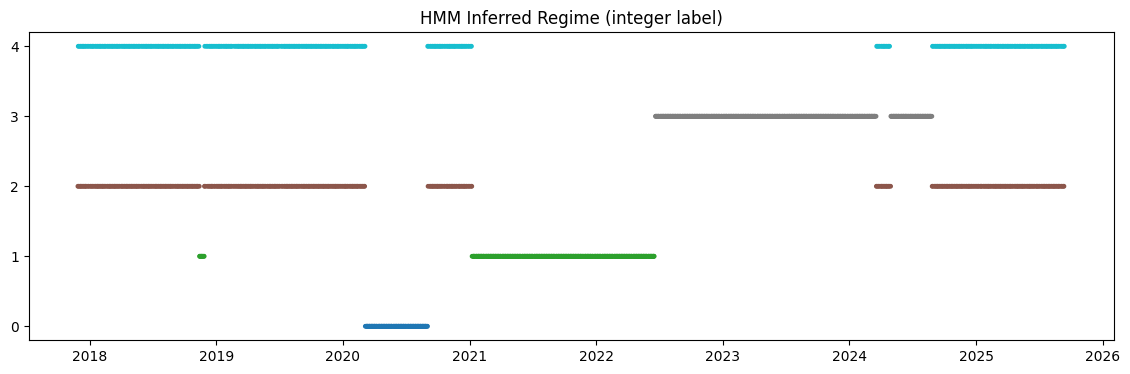

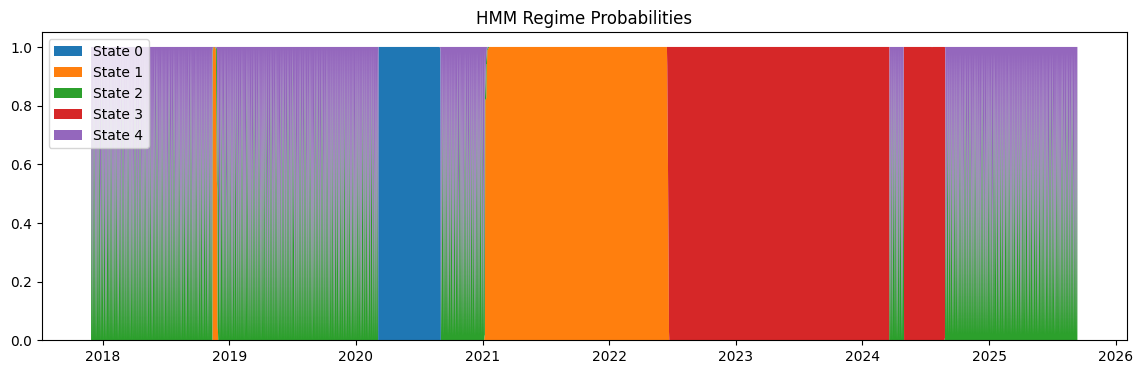

In [56]:
plt.figure(figsize=(14,4))
plt.scatter(df.index, df['regime'], c=df['regime'], cmap='tab10', s=6)
plt.title('HMM Inferred Regime (integer label)')
plt.yticks(range(model.n_components))
plt.show()

# Plot regime probabilities stacked
plt.figure(figsize=(14,4))
plt.stackplot(df.index, [df[f'regime_prob_{i}'] for i in range(model.n_components)], labels=[f'State {i}' for i in range(model.n_components)])
plt.legend(loc='upper left')
plt.title('HMM Regime Probabilities')
plt.show()



## 3.8 Example: regime-weighted risk-parity weights (illustrative)

This requires asset returns time series - if exists, can compute regime covariance matrices and then risk-parity weights per regime.


In [57]:
def risk_parity_weights(cov):
    # simple inverse-volatility allocation then normalize (approx risk parity)
    vols = np.sqrt(np.diag(cov))
    inv_vol = 1.0 / vols
    w = inv_vol / inv_vol.sum()
    return w

asset_returns = ...  # DataFrame of returns aligned with df.index
rp_weights = {}
for k, s in regime_stats.items():
    covk = asset_returns.loc[df['regime'] == k].cov()
    rp_weights[k] = risk_parity_weights(covk)

print('\nExample risk-parity weights per regime:')
for k, w in rp_weights.items():
    print(k, w.round(3))


AttributeError: 'ellipsis' object has no attribute 'loc'

## 3.9 Done: saved model, scaler, regime outputs.

In [ ]:
print('\nHMM modelling complete. Files written: hmm_model.joblib, hmm_scaler.joblib, hmm_regimes_probs.csv')